In [ ]:
# default_exp fitting

# Comparing the Instance and Classic CMR Models Using the Lohnas (2015) Dataset
To help understand how well the models account for repetition effects in free recall, we will compare the performance of the instance-based and classic-CMR models on the Lohnas (2015) dataset.

Across 4 sessions, 35 subjects performed delayed free recall of 48 lists. Subjects were University of Pennsylvania undergraduates, graduates and staff, age 18-32. List items were drawn from a pool of 1638 words taken from the University of South Florida free association norms (Nelson, McEvoy, & Schreiber, 2004; Steyvers, Shiffrin, & Nelson, 2004, available at http://memory.psych.upenn.edu/files/wordpools/PEERS_wordpool.zip). Within each session, words were drawn without replacement. Words could repeat across sessions so long as they did not repeat in two successive sessions. Words were also selected to ensure that no strong semantic associates co-occurred in a given list (i.e., the semantic relatedness between any two words on a given list, as determined using WAS (Steyvers et al., 2004), did not exceed a threshold value of 0.55).

Subjects encountered four different types of lists: 
1. Control lists that contained all once-presented items;  
2. pure massed lists containing all twice-presented items; 
3. pure spaced lists consisting of items presented twice at lags 1-8, where lag is defined as the number of intervening items between a repeated item's presentations; 
4. mixed lists consisting of once presented, massed and spaced items. Within each session, subjects encountered three lists of each of these four types. 

In each list there were 40 presentation positions, such that in the control lists each position was occupied by a unique list item, and in the pure massed and pure spaced lists, 20 unique words were presented twice to occupy the 40 positions. In the mixed lists 28 once-presented and six twice-presented words occupied the 40 positions. In the pure spaced lists, spacings of repeated items were chosen so that each of the lags 1-8 occurred with equal probability. In the mixed lists, massed repetitions (lag=0) and spaced repetitions (lags 1-8) were chosen such that each of the 9 lags of 0-8 were used exactly twice within each session. The order of presentation for the different list types was randomized within each session. For the first session, the first four lists were chosen so that each list type was presented exactly once. An experimenter sat in with the subject for these first four lists, though no subject had difficulty understanding the task.

We evaluate the model against this dataset in a few ways. First, we fit the model across the first list type and visualize summary statistics. Second, we fit the model across for each subject across all list types and visualize the distribution of log-likelihoods. Third, we fit the model across just the fourth condition and visualize recall probability as a function of number of intervening items between repetitions.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
from compmemlearn.fitting import apply_and_concatenate, cmr_murd_objective_function, icmr_murd_objective_function
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_data
from compmemlearn.analyses import recall_probability_by_lag
import pandas as pd
from psifr import fr
from scipy.optimize import differential_evolution
from numba.typed import List
import numpy as np

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


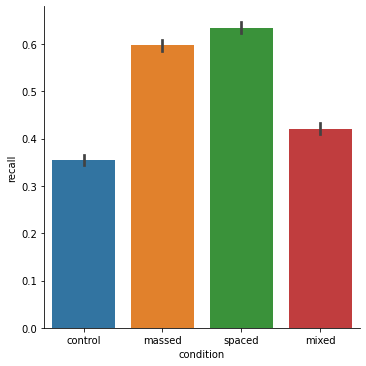

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dfs = [fr.spc(events.loc[events.condition==i]) for i in [1, 2, 3, 4]]

spc = pd.concat(dfs, keys=['control', 'massed', 'spaced', 'mixed'], names=['condition']).reset_index()

sns.catplot(data=spc, x='condition', y='recall', kind='bar')
plt.show()

# Control List Fits

### Prototype CMR

In [ ]:
# export
# hide

import numpy as np
from numba import njit
from compmemlearn.models import Classic_CMR

@njit(fastmath=True, nogil=True)
def cmr_rep_likelihood(
        trials, presentations, list_types, list_length, encoding_drift_rate, start_drift_rate, 
        recall_drift_rate, shared_support, item_support, learning_rate, 
        primacy_scale, primacy_decay, stop_probability_scale, 
        stop_probability_growth, choice_sensitivity, familiarity_scale, sampling_rule):
    """
    Generalized cost function for fitting the InstanceCMR model optimized 
    using the numba library.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.

    **Arguments**:
    - data_to_fit: typed list of int64-arrays where rows identify a unique 
        trial of responses and columns corresponds to a unique recall index.  
    - A configuration for each parameter of `InstanceCMR` as delineated in 
        `Formal Specification`.

    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """

    likelihood = np.ones((len(trials), list_length))
    
    # we can use the same model for list types 1 and 2
    stable_models = [Classic_CMR(
            list_length, list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity, familiarity_scale, sampling_rule), 
                    Classic_CMR(
            int(list_length/2), list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity, familiarity_scale, sampling_rule)]
    stable_models[0].experience(np.eye(list_length, list_length))
    stable_models[1].experience(np.eye(int(list_length/2), int(list_length/2))[np.repeat(np.arange(int(list_length/2)), 2)])

    for trial_index in range(len(trials)):

        item_count = np.max(presentations[trial_index])+1
        
        if list_types[trial_index] > 2:
            model = Classic_CMR(
                item_count, list_length, encoding_drift_rate, start_drift_rate, 
                recall_drift_rate, shared_support, item_support, learning_rate, 
                primacy_scale, primacy_decay, stop_probability_scale, 
                stop_probability_growth, choice_sensitivity, familiarity_scale, sampling_rule)

            model.experience(np.eye(item_count, item_count)[presentations[trial_index]])
        else:
            model = stable_models[list_types[trial_index]-1]
            
        trial = trials[trial_index]

        model.force_recall()
        for recall_index in range(len(trial) + 1):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentations[trial_index][trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            likelihood[trial_index, recall_index] = \
                model.outcome_probabilities(model.context)[recall]

            if recall == 0:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

def cmr_rep_objective_function(data_to_fit, presentations, list_types, list_length, fixed_parameters, free_parameters):
    """
    Generates and returns an objective function for input to support search 
    through parameter space for ICMR model fit using an optimization function.

    Arguments:  
    - fixed_parameters: dictionary mapping parameter names to values they'll 
        be fixed to during search, overloaded by free_parameters if overlap  
    - free_parameters: list of strings naming parameters for fit during search  
    - data_to_fit: array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of icmr_likelihood using the model 
    class, all parameters, and provided data.
    """
    return lambda x: cmr_rep_likelihood(data_to_fit, presentations, list_types, list_length, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [ ]:
cmr_free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
selection = list_types == 1
cost_function = cmr_rep_objective_function(
    trials[selection], presentations[selection], list_types[selection], list_length,
    {'sampling_rule': 0, 'familiarity_scale': 0}, cmr_free_parameters)

cmr_result1 = differential_evolution(cost_function, cmr_bounds, disp=False)
print(cmr_result1)

     fun: 18808.191749587008
     jac: array([ 6.12271830e-01,  2.32830642e-02, -1.39298208e+00,  1.23436621e+00,
        1.18954631e+01, -4.45132171e+01, -4.14729582e-02,  0.00000000e+00,
        2.63244146e+00, -1.81535143e-01, -1.01135811e-01])
 message: 'Optimization terminated successfully.'
    nfev: 7407
     nit: 38
 success: True
       x: array([7.34375786e-01, 5.77300237e-01, 9.32324508e-01, 3.95392711e-01,
       2.22044605e-16, 1.00000000e+00, 5.52272870e-01, 2.98544913e+01,
       2.36293468e-02, 9.12028285e-02, 5.75968685e+00])


Let's also do this with the regular cmr_murd_objective_function to confirm that our log-likelihood function works as we expect it to.

In [ ]:
model = Classic_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'sampling_rule': 0}, 
               **{cmr_free_parameters[i]:cmr_result1.x[i] for i in range(len(cmr_result1.x))}})

sim_df = simulate_data(model, 1000)
true_df = events.copy().loc[events.condition==1]

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

### InstanceCMR

In [ ]:
# export
# hide

from compmemlearn.models import Instance_CMR
import numpy as np
from numba import njit

@njit(fastmath=True, nogil=True)
def icmr_rep_likelihood(
        trials, presentations, list_types, list_length, encoding_drift_rate, start_drift_rate, 
        recall_drift_rate, shared_support, item_support, learning_rate, 
        primacy_scale, primacy_decay, stop_probability_scale, 
        stop_probability_growth, choice_sensitivity, context_sensitivity, feature_sensitivity):
    """
    Generalized cost function for fitting the InstanceCMR model optimized 
    using the numba library.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.

    **Arguments**:
    - data_to_fit: typed list of int64-arrays where rows identify a unique 
        trial of responses and columns corresponds to a unique recall index.  
    - A configuration for each parameter of `InstanceCMR` as delineated in 
        `Formal Specification`.

    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """

    likelihood = np.ones((len(trials), list_length))
    
    # we can use the same model for list types 1 and 2
    stable_models = [Instance_CMR(
            list_length, list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity, context_sensitivity, feature_sensitivity), 
                    Instance_CMR(
            int(list_length/2), list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity, context_sensitivity, feature_sensitivity)]
    stable_models[0].experience(np.eye(list_length, list_length + 1, 1))
    stable_models[1].experience(np.eye(int(list_length/2), int(list_length/2) + 1, 1)[np.repeat(np.arange(int(list_length/2)), 2)])

    for trial_index in range(len(trials)):

        item_count = np.max(presentations[trial_index])+1
        
        if list_types[trial_index] > 2:
            model = Instance_CMR(
                item_count, list_length, encoding_drift_rate, start_drift_rate, 
                recall_drift_rate, shared_support, item_support, learning_rate, 
                primacy_scale, primacy_decay, stop_probability_scale, 
                stop_probability_growth, choice_sensitivity, context_sensitivity, feature_sensitivity)

            model.experience(np.eye(item_count, item_count + 1, 1)[presentations[trial_index]])
        else:
            model = stable_models[list_types[trial_index]-1]
            
        trial = trials[trial_index]

        model.force_recall()
        for recall_index in range(len(trial) + 1):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentations[trial_index][trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            activation_cue = np.hstack(
                    (np.zeros(model.item_count + 1), model.context))
            likelihood[trial_index, recall_index] = \
                model.outcome_probabilities(activation_cue)[recall]

            if recall == 0:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

def icmr_rep_objective_function(data_to_fit, presentations, list_types, list_length, fixed_parameters, free_parameters):
    """
    Generates and returns an objective function for input to support search 
    through parameter space for ICMR model fit using an optimization function.

    Arguments:  
    - fixed_parameters: dictionary mapping parameter names to values they'll 
        be fixed to during search, overloaded by free_parameters if overlap  
    - free_parameters: list of strings naming parameters for fit during search  
    - data_to_fit: array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of icmr_likelihood using the model 
    class, all parameters, and provided data.
    """
    return lambda x: icmr_rep_likelihood(data_to_fit, presentations, list_types, list_length, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [ ]:
icmr_free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'context_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
selection = list_types == 1
cost_function = icmr_rep_objective_function(
        trials[selection], presentations[selection], list_types[selection], 
        list_length, {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
        icmr_free_parameters)

icmr_result1 = differential_evolution(cost_function, icmr_bounds, disp=True)
print(icmr_result1)

differential_evolution step 1: f(x)= 24030.9
differential_evolution step 2: f(x)= 24030.9
differential_evolution step 3: f(x)= 21976.9
differential_evolution step 4: f(x)= 21976.9
differential_evolution step 5: f(x)= 21976.9
differential_evolution step 6: f(x)= 21897.6
differential_evolution step 7: f(x)= 21897.6
differential_evolution step 8: f(x)= 21887
differential_evolution step 9: f(x)= 21827.2
differential_evolution step 10: f(x)= 21763.3
differential_evolution step 11: f(x)= 21763.3
differential_evolution step 12: f(x)= 21763.3
differential_evolution step 13: f(x)= 21763.3
differential_evolution step 14: f(x)= 21722.7
differential_evolution step 15: f(x)= 21717
differential_evolution step 16: f(x)= 21708.7
differential_evolution step 17: f(x)= 21708.7
differential_evolution step 18: f(x)= 21518.9
differential_evolution step 19: f(x)= 20921.9
differential_evolution step 20: f(x)= 20921.9
differential_evolution step 21: f(x)= 20445.8
differential_evolution step 22: f(x)= 20434.4
d

A similar sanity check of our objective function:

In [ ]:
model = Instance_CMR(
    **{**{'item_count': list_length, 'presentation_count': list_length, 'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    **{icmr_free_parameters[i]:icmr_result1.x[i] for i in range(len(icmr_result1.x))}})

sim_df = simulate_data(model, 1000)
icmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['InstanceCMR', 'data'])
icmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr = icmr_pfr.query('output <= 1')

icmr_pfr.head()

,source,subject,output,input,prob,actual,possible
0,InstanceCMR,0,1,1,1.0,1,1
1,InstanceCMR,0,1,2,0.0,0,1
2,InstanceCMR,0,1,3,0.0,0,1
3,InstanceCMR,0,1,4,0.0,0,1
4,InstanceCMR,0,1,5,0.0,0,1


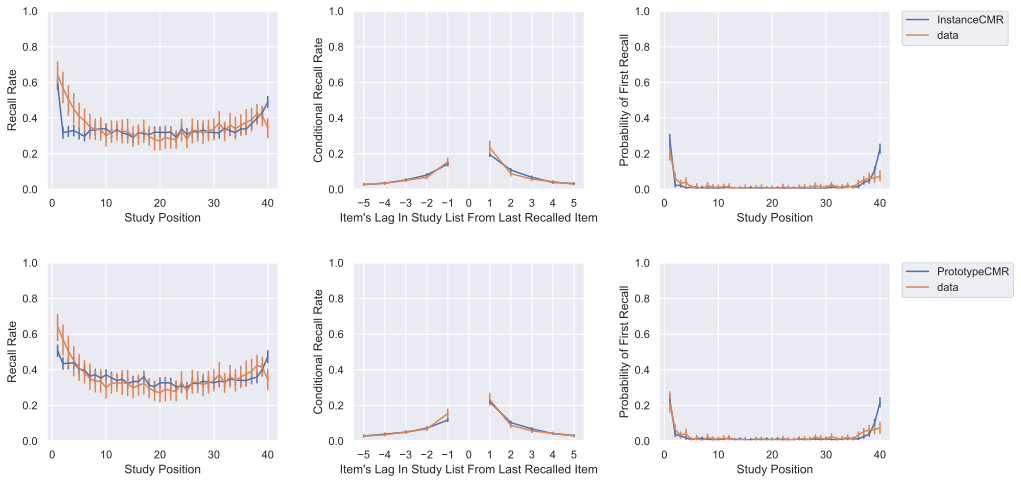

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15/2), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
#axes[0, 0].set_xticks(np.arange(1, 21, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Study Position', ylabel='Recall Rate')
#axes[1, 0].set_xticks(np.arange(1, 21, 2))
axes[1, 0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[0, 1].set_xticks(np.arange(-5, 6, 1))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr, x='input', y='prob', err_style='bars', ax=axes[0, 2], hue='source')
axes[0, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
#axes[0, 2].set_xticks(np.arange(1, 21, 2))
axes[0, 2].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[1, 2], hue='source')
axes[1, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
#axes[1, 2].set_xticks(np.arange(1, 21, 2))
axes[1, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('summary_lohnas2015_1.png', bbox_inches='tight')